# 📁 Project Setup
Import libraries and set up reproducibility.


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

# 🧪 Simulated Dataset
Generating synthetic rTMS response dataset for binary classification.

In [ ]:
# Number of patients
n = 200

# Generate features
age = np.random.randint(18, 75, size=n)
sex = np.random.choice(['M', 'F'], size=n)
phq9 = np.random.randint(10, 28, size=n)  # Typical depression scores
illness_duration = np.random.randint(3, 121, size=n)  # In months
frequency = np.random.choice(['1 Hz', '10 Hz', 'iTBS'], size=n)
target = np.random.choice(['Left DLPFC', 'Right DLPFC'], size=n)
pulse_count = np.random.randint(600, 3001, size=n)
sessions = np.random.randint(10, 31, size=n)

# Simulate response: 1 = Responder, 0 = Non-responder
response = []
for i in range(n):
    f = frequency[i]
    t = target[i]
    total_pulses = pulse_count[i] * sessions[i]

    if f == '10 Hz' and t == 'Left DLPFC' and total_pulses > 40000:
        response.append(np.random.choice([1, 0], p=[0.9, 0.1]))
    else:
        response.append(np.random.choice([1, 0], p=[0.3, 0.7]))


# Create a DataFrame
data = pd.DataFrame({
    'Age': age,
    'Sex': sex,
    'PHQ9_Score': phq9,
    'Illness_Duration_Months': illness_duration,
    'Frequency': frequency,
    'Target_Area': target,
    'Pulse_Count': pulse_count,
    'Sessions': sessions,
    'Response': response
})

# New feature: Total number of pulses across all sessions
data['Total_Pulses'] = data['Pulse_Count'] * data['Sessions']

# Balance the Classes of responders and non-responders

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = data[data.Response == 0]
df_minority = data[data.Response == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,      # Sample with replacement
                                 n_samples=len(df_majority),  # Match majority
                                 random_state=42)

# Combine back to balanced dataset
data = pd.concat([df_majority, df_minority_upsampled])


# 📊 Exploratory Data Analysis
Initial look at the dataset (distributions, class balance, etc.).


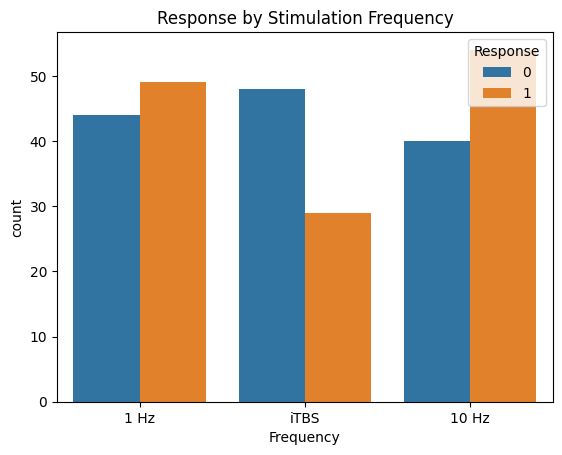

In [ ]:
# Exploring the Data
data.head()
data.shape
data.columns
data.describe()
data['Sex'].value_counts()
data['Frequency'].value_counts()
data['Target_Area'].value_counts()
data['Response'].value_counts()
data.groupby('Response')['PHQ9_Score'].mean()
data.groupby('Response')['Sessions'].mean()

sns.countplot(x='Frequency', hue='Response', data=data)
plt.title("Response by Stimulation Frequency")
plt.show()


# 🧼 Data Preprocessing

In [ ]:
# Preprocessing the Data

X = data.drop('Response', axis=1)  # All features
y = data['Response']               # The target label

X_encoded = pd.get_dummies(X, drop_first=True) # Turning strings into mutliple colums of binary

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded) # Standardising to prevent non-important overpowering variables

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)


# 📈 Logistic Regression
Train and evaluate a logistic regression model as a baseline.


Accuracy: 0.5471698113207547
Confusion Matrix:
[[17  9]
 [15 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.65      0.59        26
           1       0.57      0.44      0.50        27

    accuracy                           0.55        53
   macro avg       0.55      0.55      0.54        53
weighted avg       0.55      0.55      0.54        53

ROC AUC Score: 0.5612535612535612


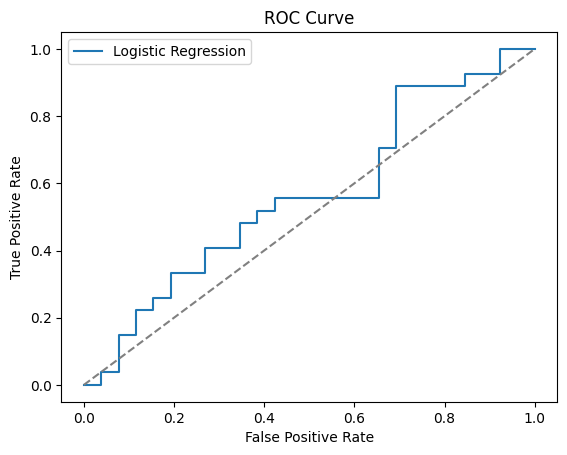

In [ ]:
# Logisitc Regression Model

from sklearn.linear_model import LogisticRegression

# Create the model
model = LogisticRegression()

# Train (fit) the model to your data
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Predict response or not (0 or 1)
y_probs = model.predict_proba(X_test)[:, 1] # Predict probability of response (0-1)

# Evaluate the Model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Accuracy: what % the model got right
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix: TP, TN, FP, FN
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Full classification report: precision, recall, F1
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC: how good are the probability scores
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

# ROC Curve Visualisation

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 🌳 Random Forest Classifier
Train and evaluate a more powerful model.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_probs))


Random Forest Accuracy: 0.8113207547169812
[[19  7]
 [ 3 24]]
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.77      0.89      0.83        27

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53

ROC AUC Score: 0.9287749287749287


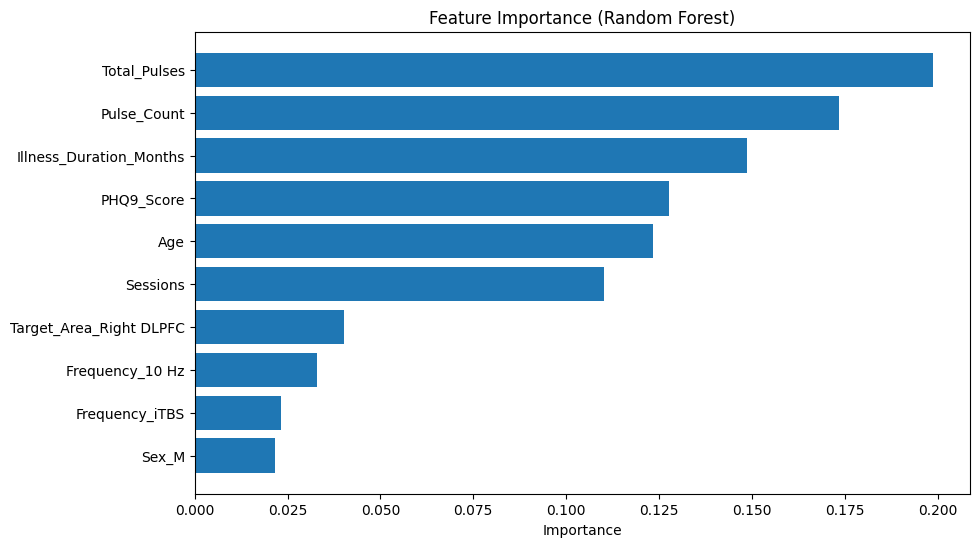

In [ ]:
# Feature Important Analysis

importances = rf_model.feature_importances_
feature_names = X_encoded.columns

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()


